<a href="https://colab.research.google.com/github/mrmohamedsalah/RNN_sentiment_analysis/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import kagglehub
import os

# Retrieve the latest Yelp review dataset
dataset_path = kagglehub.dataset_download("astandrik/yelp-review")

print("Dataset location:", dataset_path)

100%|██████████| 3.49M/3.49M [00:01<00:00, 2.90MB/s]

Extracting files...
Dataset location: /root/.cache/kagglehub/datasets/astandrik/yelp-review/versions/1


In [2]:
# Locate the CSV file in the downloaded directory
csv_file = None
for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        csv_file = os.path.join(dataset_path, filename)
        break

# Load dataset into DataFrame
data = pd.read_csv(csv_file)

# Prepare data for sentiment analysis
data = data[['text', 'stars']]

# Create binary sentiment classification
data = data[data['stars'] != 3]  # Remove neutral reviews
data['sentiment'] = data['stars'].apply(lambda x: 1 if x > 3 else 0)

# Sample dataset
sample_size = min(12000, len(data))
data = data.sample(sample_size, random_state=24)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.25, random_state=24)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 6404, Testing samples: 2135


In [4]:

VOCAB_SIZE = 15000  # Unique word limit
SEQUENCE_LENGTH = 120  # Maximum sequence length

# Tokenization process
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<RARE>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Sequence padding
X_train_pad = pad_sequences(X_train_seq, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post')

In [5]:
# Import necessary Keras components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the RNN model
model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=SEQUENCE_LENGTH),  # Embedding layer
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),  # Bidirectional LSTM
    LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),  # Additional LSTM layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20, batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

# Save the trained model
model.save("bidirectional_lstm_yelp_sentiment.h5")

print("Model training completed successfully")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8015 - loss: 0.5422 - val_accuracy: 0.7948 - val_loss: 0.5067 - learning_rate: 5.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8123 - loss: 0.4802 - val_accuracy: 0.8056 - val_loss: 0.4750 - learning_rate: 5.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8322 - loss: 0.4349 - val_accuracy: 0.8098 - val_loss: 0.4658 - learning_rate: 5.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8688 - loss: 0.3624 - val_accuracy: 0.8201 - val_loss: 0.4598 - learning_rate: 5.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8808 - loss: 0.3213 - val_accuracy: 0.8244 - val_loss: 0.4923 - learning_rate: 5.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9064 - loss: 0.2385
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
101/101 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 

Model training completed successfully


In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.8247 - loss: 0.4512
Test Loss: 0.4598
Test Accuracy: 0.8201


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict sentiment on test data
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step
              precision    recall  f1-score   support

           0       0.62      0.31      0.41       438
           1       0.84      0.95      0.89      1697

    accuracy                           0.82      2135
   macro avg       0.73      0.63      0.65      2135
weighted avg       0.80      0.82      0.80      2135



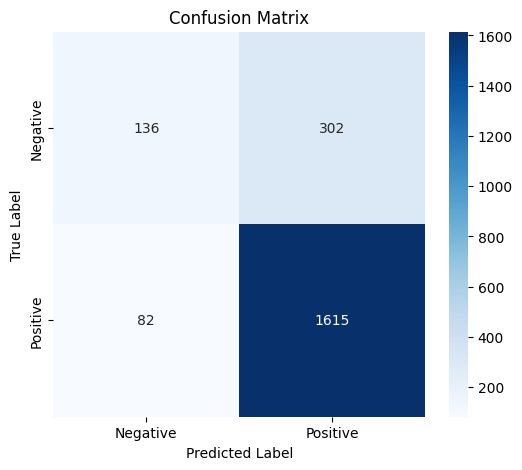

In [8]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
model = tf.keras.models.load_model("bidirectional_lstm_yelp_sentiment.h5")
example_reviews = [
    "This restaurant had amazing food and excellent service! I would definitely come back.",
    "The pizza was cold and the service was horrible. Never going there again!",
    "Meh, it was okay. Nothing special, but not terrible either.",
    "Absolutely loved the ambiance and the food was top-notch!",
    "The wait time was way too long, and the food was undercooked.",
    "Staff was friendly, but the food was overpriced for the quality.",
    "One of the best meals I’ve ever had! Highly recommend this place!",
    "I regret coming here. The food was bland and the portions were tiny."
]

# Test each review
for review in example_reviews:
    predict_sentiment(review, model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Review: This restaurant had amazing food and excellent service! I would definitely come back.
Predicted Sentiment: Positive (Confidence: 0.8723)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Review: The pizza was cold and the service was horrible. Never going there again!
Predicted Sentiment: Positive (Confidence: 0.8723)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Review: Meh, it was okay. Nothing special, but not terrible either.
Predicted Sentiment: Positive (Confidence: 0.8723)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Review: Absolutely loved the ambiance and the food was top-notch!
Predicted Sentiment: Positive (Confidence: 0.8723)
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Review: The wait time was way too long, and the fo